In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import theano.tensor.slinalg as sla

In [2]:
dataset=[]
with open("HSTest_Normalized.txt","r") as f:
    data = []
    for line in f:
        if line.strip()=="":
            dataset.append(np.array(data))
            data=[]
        else:
            data.append(float(line.strip()))
    dataset.append(data)
dataset=np.array(dataset)


In [3]:
print(dataset.shape)

(208,)


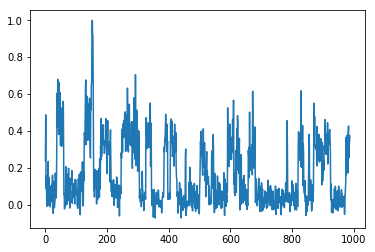

In [4]:
plt.plot(dataset[205])

In [5]:
# Two state model for simplicity.
N_states = 2
N_chain = len(dataset[30])

# Transition probability stochastic
theta = np.ones(N_states) + 1.
alphaA1 = 2.1
betaA1 = 1.1
alphaA2 = 2.1
betaA2 = 1.1
# inv gamma for S
# mean = beta/(alpha-1), var = beta**2/(alpha-1)**2/(alpha-2) = mean**2/(alpha-2)
# I want mean=0.2, var=mean**2
alphaS = 3.0
betaS = 0.2*2

subdataset = dataset
data = np.concatenate(subdataset)
N_samples=subdataset.shape[0]
print(data.shape)

(204516,)


In [6]:
class HMMStatesNStack(pm.Categorical):
    """
    Hidden Markov Model States
    Parameters
    ----------
    P : tensor
        transition probability
        shape = (N_states,N_states)
        
    PA : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, PA=None, P=None, N_states=2, N_samples=2,
                 *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.P = P
        self.PA = PA
        self.k = N_states
        self.N_samples = N_samples
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        P = self.P
        PA = self.PA
        N_samples = self.N_samples
        
        # length of states
        # length = x.shape[0]//N_samples
        length = tt.cast(x.shape[0]//N_samples, 'int64')
        # first shift the whole states array one to the right
        # and then do some smart indexing magic
        PS = P[tt.roll(x,shift=1)]
        # now our array is correct except for the first elements:
        # 0,length,2*length,...(N_samples-1)*length
        # we need to create a vector with indices
        p_index = tt.cast(tt.arange(N_samples)*length, 'int64')
        PS = tt.set_subtensor(PS[p_index],PA)
        #slowest method
#        PAA = PA[:,np.newaxis].T
#        PL = [tt.concatenate([PAA, P[x[i*length:(i+1)*length-1]]]) for i in range(N_samples)]
#        PS = tt.concatenate(PL)
        # second slowest method
#        PL = [P[x[i*length:(i+1)*length-1]] for i in range(N_samples)]
#        PS = tt.concatenate([x for xs in zip([PAA]*N_samples,PL) for x in xs])
        ou_like = pm.Categorical.dist(PS).logp(x)
        return tt.sum(ou_like)

In [7]:
class HMMGaussianEmissions(pm.Continuous):
    """
    Hidden Markov Model Gaussian Emissions
    Parameters
    ----------
    A : tensor
        prior for Gaussian emission mu
        shape = (2,N_states)
        
    S : tensor
        prior for Gaussian emission width
        shape = (2,N_states)
    
    states : tensor
         equilibrium probabilities
         shape = (N_states)
    
    """

    def __init__(self, A1=None, A2=None, S1=None, S2=None, states=None,
                 *args, **kwargs):
        super(HMMGaussianEmissions, self).__init__(*args, **kwargs)
        self.A1 = A1
        self.S1 = S1
        self.A2 = A2
        self.S2 = S2
        self.states = states
        self.mean = 0.

    def logp(self, x):
        A1 = self.A1
        S1 = self.S1
        A2 = self.A2
        S2 = self.S2
        states = self.states
        
        AT = tt.stack((A1,A2))
        AS = AT[states]
        
        ST = tt.stack((S1,S2))
        SS = ST[states]
        
        ou_like = pm.Normal.dist(mu=AS,sd=SS).logp(x)
        return tt.sum(ou_like)

In [ ]:
#theano.config.exception_verbosity = 'high'
from scipy import optimize
with pm.Model() as model:
    # 2 state model
    P = pm.Dirichlet('P', a=np.ones((N_states,N_states)), shape=(N_states,N_states))
    
    A1 = pm.Normal('A1',mu=0, sd=0.3)
    A2 = pm.Normal('A2',mu=1, sd=0.3)
    S1 = pm.InverseGamma('S1',alpha=alphaS, beta=betaS)
    S2 = pm.InverseGamma('S2',alpha=alphaS, beta=betaS)
    
    AA = tt.dmatrix('AA')
        
    AA = tt.eye(N_states) - P + tt.ones(shape=(N_states,N_states))
    
    PA = pm.Deterministic('PA',sla.solve(AA.T,tt.ones(shape=(N_states))))
    
    states = HMMStatesNStack('states',P=P,PA=PA,N_samples=N_samples,shape=len(data))
    
    emission = HMMGaussianEmissions('emission',
                                    A1=A1,
                                    A2=A1,
                                    S1=S1,
                                    S2=S2,
                                    states=states,
                                    observed = data)
    
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    step1 = pm.Metropolis(vars=[P, PA, A1, A2, S1, S2, emission])
    step2 = pm.BinaryGibbsMetropolis(vars=[states])
    trace = pm.sample(1000, start=start, step=[step1, step2])

Optimization terminated successfully.
         Current function value: -53249.295104
         Iterations: 3
         Function evaluations: 308


  0%|          | 2/1000 [1:19:12<656:03:12, 2366.53s/it]

In [ ]:
pm.traceplot(trace)

In [ ]:
sample_avg=np.average(trace['states'][500:],axis=0)

In [ ]:
plt.plot(data)
plt.plot((sample_avg)*0.6)

In [ ]:
pm.summary(trace[500:])